#Data Loading, Preparation and Preprocessing

In [10]:
import os, re, json, pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, HTML

# ---- Notebook display tweaks so long reasons are visible --------------------
pd.set_option('display.max_colwidth', None)   # show full reason text
pd.set_option('display.width', 240)
pd.set_option('display.max_columns', 50)

LOCAL_CSV = None  # e.g. "/content/Tweets.csv"
SEED = 42
MAX_VOCAB = 20000
MAX_LEN = 128
tfidf_max_features = 20000

def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P']:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

# ---- Full reason map for original columns + derived ones --------------------
column_policy = {
    'tweet_id': {'action': 'DROP', 'reason': "Unique identifier per tweet — not a model feature and high-cardinality."},
    'airline_sentiment': {'action': 'KEEP_MEMORY_ONLY', 'reason': "Original categorical sentiment; used only to create numeric label."},
    'airline_sentiment_confidence': {'action': 'KEEP_MEMORY_ONLY', 'reason': "Annotation confidence; meta-only, not used by this text-only model."},
    'negativereason': {'action': 'MERGE_TO_TEXT', 'reason': "Short categorical cue; merged into text_clean to preserve signal."},
    'negativereason_confidence': {'action': 'DROP', 'reason': "Meta quality indicator; not needed for classification."},
    'airline': {'action': 'KEEP_MEMORY_ONLY', 'reason': "Airline name; could be used later as metadata feature, not in this run."},
    'airline_sentiment_gold': {'action': 'DROP', 'reason': "Almost entirely missing (annotation gold) — no useful data."},
    'name': {'action': 'DROP', 'reason': "User/display name — high-cardinality and privacy/noise concerns."},
    'negativereason_gold': {'action': 'DROP', 'reason': "Almost entirely missing (gold) — no useful data."},
    'retweet_count': {'action': 'KEEP_MEMORY_ONLY', 'reason': "Numeric meta feature; not used in this text-only model."},
    'text': {'action': 'KEEP_MEMORY_ONLY', 'reason': "Raw tweet body; cleaned into text_clean."},
    'tweet_coord': {'action': 'DROP', 'reason': "Over 90% missing coordinates — extremely sparse and inconsistent."},
    'tweet_created': {'action': 'DROP', 'reason': "Datetime with high cardinality — not used for this text-only model."},
    'tweet_location': {'action': 'DROP', 'reason': "Noisy user-provided location with ~32% missing — unreliable."},
    'user_timezone': {'action': 'DROP', 'reason': "Many missing values (~33%) and noisy — not useful for modeling."},
    # derived
    'text_clean': {'action': 'MODEL_INPUT', 'reason': "Preprocessed text — **only input feature** used by models."},
    'label': {'action': 'TARGET', 'reason': "Encoded sentiment (0=neg,1=neu,2=pos) — **only target**."},
}

# ---- Locate CSV robustly ----------------------------------------------------
csv_file = None
try:
    import kagglehub
    kpath = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")
    candidate = os.path.join(kpath, "Tweets.csv")
    if os.path.exists(candidate):
        csv_file = candidate
        print("Using Colab cache for faster access to the 'twitter-airline-sentiment' dataset.")
except Exception:
    pass

if csv_file is None:
    if LOCAL_CSV and os.path.exists(LOCAL_CSV):
        csv_file = LOCAL_CSV
    else:
        raise RuntimeError("Could not locate dataset. Set LOCAL_CSV path or enable kagglehub.")

print("Using CSV:", csv_file)

# ---- Read raw and keep original copy for column stats -----------------------
df_raw_orig = pd.read_csv(csv_file)
df_raw = df_raw_orig.copy()
print("Raw shape:", df_raw.shape)
display(df_raw.head(3))

# ---- Defensive drop of known-noisy columns ---------------------------------
to_drop = [c for c, meta in column_policy.items() if meta['action'] == 'DROP' and c in df_raw.columns]
if to_drop:
    df_raw = df_raw.drop(columns=to_drop, errors='ignore')
    print("Dropped columns:", to_drop)

# ---- Essential columns check ------------------------------------------------
if 'text' not in df_raw.columns or 'airline_sentiment' not in df_raw.columns:
    raise RuntimeError("Required columns 'text' and/or 'airline_sentiment' missing in CSV.")

# ---- Basic fills ------------------------------------------------------------
df = df_raw.copy()
df['text'] = df['text'].fillna("").astype(str)
df['airline_sentiment'] = df['airline_sentiment'].astype(str).str.lower().str.strip().fillna("")

# ---- Label mapping ----------------------------------------------------------
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
def map_label(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, np.integer)) and int(x) in {0,1,2}:
        return int(x)
    return label_map.get(str(x).lower().strip(), np.nan)

df['label'] = df['airline_sentiment'].apply(map_label)
before = len(df)
df = df[~df['label'].isna()].copy()
after = len(df)
print(f"Dropped {before-after} rows without valid sentiment mapping. Remaining: {after}")

# ---- Text cleaning ----------------------------------------------------------
def clean_text_remove_mentions(text: str) -> str:
    if pd.isna(text): return ""
    s = str(text).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)                 # urls
    s = re.sub(r"@\w+", " ", s)                           # mentions
    s = re.sub(r"[^a-z0-9\s]", " ", s)                    # keep a-z0-9
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text_remove_mentions)

# ---- Optional: merge negativereason into text_clean -------------------------
if 'negativereason' in df.columns:
    df['negativereason'] = df['negativereason'].fillna("").astype(str)
    df['text_clean'] = (df['negativereason'].str.strip().replace({'': np.nan}).fillna('') + ' ' + df['text_clean']).str.strip()
    print("Merged 'negativereason' into 'text_clean' (action=MERGE_TO_TEXT).")

# ---- Show sample ------------------------------------------------------------
display(df[['text', 'text_clean', 'airline_sentiment', 'label']].head(5))

# ---- Splits (70/15/15 stratified) ------------------------------------------
train_val, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=SEED)
train, val = train_test_split(train_val, test_size=0.1764706, stratify=train_val['label'], random_state=SEED)
print("Splits -> train:", len(train), "val:", len(val), "test:", len(test))

# ---- Tokenizer & padded sequences (DL path) ---------------------------------
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train['text_clean'].astype(str).tolist())

def make_seq(df_input):
    seq = tokenizer.texts_to_sequences(df_input['text_clean'].astype(str).tolist())
    seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    return seq

X_train_seq = make_seq(train); X_val_seq = make_seq(val); X_test_seq = make_seq(test)
y_train = train['label'].astype(int).values
y_val   = val['label'].astype(int).values
y_test  = test['label'].astype(int).values
print("Sequence shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)

# ---- TF-IDF (classical path) ------------------------------------------------
tfidf = TfidfVectorizer(max_features=tfidf_max_features, ngram_range=(1,2), token_pattern=r"(?u)\b[a-z0-9]+\b")
tfidf.fit(train['text_clean'].astype(str).tolist())
X_train_tfidf = tfidf.transform(train['text_clean'].astype(str).tolist())
X_val_tfidf   = tfidf.transform(val['text_clean'].astype(str).tolist())
X_test_tfidf  = tfidf.transform(test['text_clean'].astype(str).tolist())
print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

# ---- Save ONLY the modeling columns -----------------------------------------
os.makedirs("/content/datasets", exist_ok=True)
train_reset = train.reset_index(drop=True)[['text_clean','label']]
val_reset   = val.reset_index(drop=True)[['text_clean','label']]
test_reset  = test.reset_index(drop=True)[['text_clean','label']]
train_reset.to_csv("/content/datasets/train.csv", index=False)
val_reset.to_csv("/content/datasets/val.csv", index=False)
test_reset.to_csv("/content/datasets/test.csv", index=False)

# Tokenizer & vectorizer artifacts
with open("/content/datasets/keras_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("/content/datasets/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("Saved cleaned CSVs and artifacts to /content/datasets/")

# ---- STRICT VALIDATION: only text_clean & label go to modeling --------------
for name, dfi in [('train.csv', train_reset), ('val.csv', val_reset), ('test.csv', test_reset)]:
    cols = list(dfi.columns)
    assert cols == ['text_clean','label'], f"{name} has unexpected columns: {cols}"
    assert dfi['label'].isin([0,1,2]).all(), f"{name} contains invalid labels."

# ---- Human-readable summary & README (and PRINT the decisions table) ---------
total_model_rows = len(train_reset) + len(val_reset) + len(test_reset)
print("\nModeling dataset summary:")
print(f" - Rows going to modelling: {total_model_rows} (train={len(train_reset)}, val={len(val_reset)}, test={len(test_reset)})")

files_to_check = [
    "/content/datasets/train.csv",
    "/content/datasets/val.csv",
    "/content/datasets/test.csv",
    "/content/datasets/keras_tokenizer.pkl",
    "/content/datasets/tfidf_vectorizer.pkl"
]
for p in files_to_check:
    size = os.path.getsize(p) if os.path.exists(p) else 0
    print(f" - {os.path.basename(p)}: {sizeof_fmt(size) if size else 'NOT FOUND'}")

# Build a compact decisions table for display & README, with extra drop-statistics
present_raw_cols = list(df_raw_orig.columns)   # original CSV columns order
decisions = []
drop_stats_rows = []
n_total = len(df_raw_orig)
for c in present_raw_cols:
    meta = column_policy.get(c, {'action':'(unknown)','reason':'No policy found.'})
    row = {'column': c, 'action': meta['action'], 'reason': meta['reason']}
    # If action is DROP compute stats from the original dataframe (missing%, unique, top value)
    if meta['action'] == 'DROP':
        series = df_raw_orig[c]
        missing_count = int(series.isna().sum())
        missing_pct = float(missing_count) / n_total * 100
        unique_count = int(series.nunique(dropna=True))
        # top value and frequency (if many unique handle gracefully)
        try:
            top = series.mode().iloc[0] if not series.mode().empty else None
            top_freq = int((series == top).sum()) if top is not None else 0
        except Exception:
            top = None; top_freq = 0
        # small sample of distinct non-null values (up to 5)
        sample_vals = list(pd.Series(series.dropna().unique()[:5]).astype(str))
        sample_preview = ", ".join(sample_vals)
        # attach stats
        row.update({
            'missing_count': missing_count,
            'missing_pct': round(missing_pct, 2),
            'unique_count': unique_count,
            'top_value': str(top) if top is not None else "",
            'top_freq': top_freq,
            'sample_preview': sample_preview
        })
    else:
        # keep empty stats for non-DROP for table consistency
        row.update({
            'missing_count': "",
            'missing_pct': "",
            'unique_count': "",
            'top_value': "",
            'top_freq': "",
            'sample_preview': ""
        })
    decisions.append(row)

# add derived
for c in ['text_clean','label']:
    meta = column_policy[c]
    decisions.append({
        'column': c, 'action': meta['action'], 'reason': meta['reason'],
        'missing_count': '', 'missing_pct': '', 'unique_count':'', 'top_value':'', 'top_freq':'', 'sample_preview':''
    })

# Display as pandas DataFrame (full-width so reasons appear)
df_decisions = pd.DataFrame(decisions)
# ensure columns order for readability
cols_display = ['column','action','reason','missing_count','missing_pct','unique_count','top_value','top_freq','sample_preview']
df_decisions = df_decisions[cols_display]
display(HTML(df_decisions.to_html(index=False, escape=False)))

# Also present a focused table of only the DROP columns for quick review
df_drops = df_decisions[df_decisions['action'] == 'DROP'].copy()
if not df_drops.empty:
    print("\nDetailed stats for columns with action = DROP:")
    display(HTML(df_drops.to_html(index=False, escape=False)))
else:
    print("\nNo columns were marked DROP in the policy and present in the CSV.")

# Write README with same table (extended with drop stats)
readme_lines = [
    "# Dataset Preprocessing Summary",
    "",
    f"- Source CSV: `{csv_file}`",
    f"- Total rows used for modeling: **{total_model_rows}** (train={len(train_reset)}, val={len(val_reset)}, test={len(test_reset)})",
    "",
    "## Column Decisions (extended with stats for columns removed)",
    "",
    "| Column | Action | Reason | missing_count | missing_pct | unique_count | top_value | top_freq | sample_preview |",
    "|---|---|---|---:|---:|---:|---|---:|---|",
]
for row in decisions:
    readme_lines.append(
        "| `{col}` | {action} | {reason} | {missing_count} | {missing_pct} | {unique_count} | {top_value} | {top_freq} | {sample} |".format(
            col=row['column'],
            action=row['action'],
            reason=row['reason'].replace("\n", " ").replace("|", "\\|"),
            missing_count=row.get('missing_count', ''),
            missing_pct=row.get('missing_pct', ''),
            unique_count=row.get('unique_count', ''),
            top_value=str(row.get('top_value','')).replace("|", "\\|"),
            top_freq=row.get('top_freq',''),
            sample=str(row.get('sample_preview','')).replace("|", "\\|")
        )
    )

readme = "\n".join(readme_lines)
with open("/content/datasets/README.md", "w", encoding="utf-8") as f:
    f.write(readme)
print("\nWrote /content/datasets/README.md with full column decisions and drop-stats.")


Using Colab cache for faster access to the 'twitter-airline-sentiment' dataset.
Using CSV: /root/.cache/kagglehub/datasets/crowdflower/twitter-airline-sentiment/versions/4/Tweets.csv
Raw shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


Dropped columns: ['tweet_id', 'negativereason_confidence', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
Dropped 0 rows without valid sentiment mapping. Remaining: 14640
Merged 'negativereason' into 'text_clean' (action=MERGE_TO_TEXT).


,text,text_clean,airline_sentiment,label
0,@VirginAmerica What @dhepburn said.,what said,neutral,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you ve added commercials to the experience tacky,positive,2
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,i didn t today must mean i need to take another trip,neutral,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",Bad Flight it s really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,negative,0
4,@VirginAmerica and it's a really big bad thing about it,Can't Tell and it s a really big bad thing about it,negative,0


Splits -> train: 10247 val: 2197 test: 2196
Sequence shapes: (10247, 128) (2197, 128) (2196, 128)
TF-IDF shapes: (10247, 20000) (2197, 20000) (2196, 20000)
Saved cleaned CSVs and artifacts to /content/datasets/

Modeling dataset summary:
 - Rows going to modelling: 14640 (train=10247, val=2197, test=2196)
 - train.csv: 1001.4KB
 - val.csv: 216.8KB
 - test.csv: 213.0KB
 - keras_tokenizer.pkl: 417.8KB
 - tfidf_vectorizer.pkl: 753.5KB


column,action,reason,missing_count,missing_pct,unique_count,top_value,top_freq,sample_preview
tweet_id,DROP,Unique identifier per tweet — not a model feature and high-cardinality.,0,0.0,14485,569600137296633856,2,"570306133677760513, 570301130888122368, 570301083672813571, 570301031407624196, 570300817074462722"
airline_sentiment,KEEP_MEMORY_ONLY,Original categorical sentiment; used only to create numeric label.,,,,,,
airline_sentiment_confidence,KEEP_MEMORY_ONLY,"Annotation confidence; meta-only, not used by this text-only model.",,,,,,
negativereason,MERGE_TO_TEXT,Short categorical cue; merged into text_clean to preserve signal.,,,,,,
negativereason_confidence,DROP,Meta quality indicator; not needed for classification.,4118,28.13,1410,1.0,3436,"0.0, 0.7033, 1.0, 0.6842, 0.3684"
airline,KEEP_MEMORY_ONLY,"Airline name; could be used later as metadata feature, not in this run.",,,,,,
airline_sentiment_gold,DROP,Almost entirely missing (annotation gold) — no useful data.,14600,99.73,3,negative,32,"negative, neutral, positive"
name,DROP,User/display name — high-cardinality and privacy/noise concerns.,0,0.0,7701,JetBlueNews,63,"cairdin, jnardino, yvonnalynn, cjmcginnis, pilot"
negativereason_gold,DROP,Almost entirely missing (gold) — no useful data.,14608,99.78,13,Customer Service Issue,12,"Late Flight\nFlight Attendant Complaints, Late Flight\nLost Luggage, Late Flight, Customer Service Issue, Can't Tell"
retweet_count,KEEP_MEMORY_ONLY,Numeric meta feature; not used in this text-only model.,,,,,,



Detailed stats for columns with action = DROP:


column,action,reason,missing_count,missing_pct,unique_count,top_value,top_freq,sample_preview
tweet_id,DROP,Unique identifier per tweet — not a model feature and high-cardinality.,0,0.0,14485,569600137296633856,2,"570306133677760513, 570301130888122368, 570301083672813571, 570301031407624196, 570300817074462722"
negativereason_confidence,DROP,Meta quality indicator; not needed for classification.,4118,28.13,1410,1.0,3436,"0.0, 0.7033, 1.0, 0.6842, 0.3684"
airline_sentiment_gold,DROP,Almost entirely missing (annotation gold) — no useful data.,14600,99.73,3,negative,32,"negative, neutral, positive"
name,DROP,User/display name — high-cardinality and privacy/noise concerns.,0,0.0,7701,JetBlueNews,63,"cairdin, jnardino, yvonnalynn, cjmcginnis, pilot"
negativereason_gold,DROP,Almost entirely missing (gold) — no useful data.,14608,99.78,13,Customer Service Issue,12,"Late Flight\nFlight Attendant Complaints, Late Flight\nLost Luggage, Late Flight, Customer Service Issue, Can't Tell"
tweet_coord,DROP,Over 90% missing coordinates — extremely sparse and inconsistent.,13621,93.04,832,"[0.0, 0.0]",164,"[40.74804263, -73.99295302], [42.361016, -71.02000488], [33.94540417, -118.4062472], [33.94209449, -118.40410103], [33.2145038, -96.9321504]"
tweet_created,DROP,Datetime with high cardinality — not used for this text-only model.,0,0.0,14247,2015-02-24 09:54:34 -0800,5,"2015-02-24 11:35:52 -0800, 2015-02-24 11:15:59 -0800, 2015-02-24 11:15:48 -0800, 2015-02-24 11:15:36 -0800, 2015-02-24 11:14:45 -0800"
tweet_location,DROP,Noisy user-provided location with ~32% missing — unreliable.,4733,32.33,3081,"Boston, MA",157,"Lets Play, San Francisco CA, Los Angeles, San Diego, 1/1 loner squad"
user_timezone,DROP,Many missing values (~33%) and noisy — not useful for modeling.,4820,32.92,85,Eastern Time (US & Canada),3744,"Eastern Time (US & Canada), Pacific Time (US & Canada), Central Time (US & Canada), America/New_York, Atlantic Time (Canada)"



Wrote /content/datasets/README.md with full column decisions and drop-stats.


#Class distributions and WordCloud visualizations — Train / Validation / Test

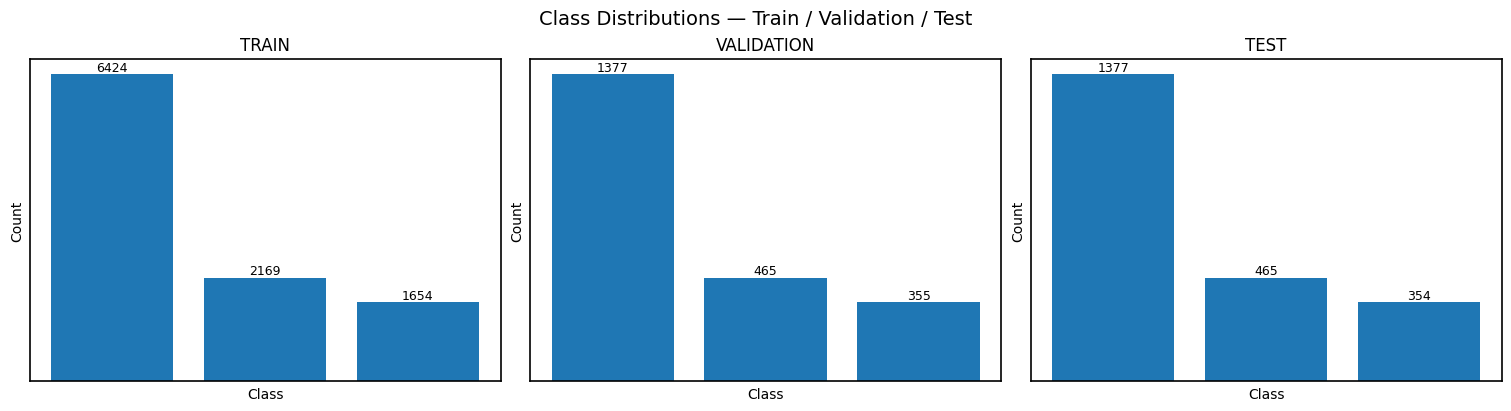

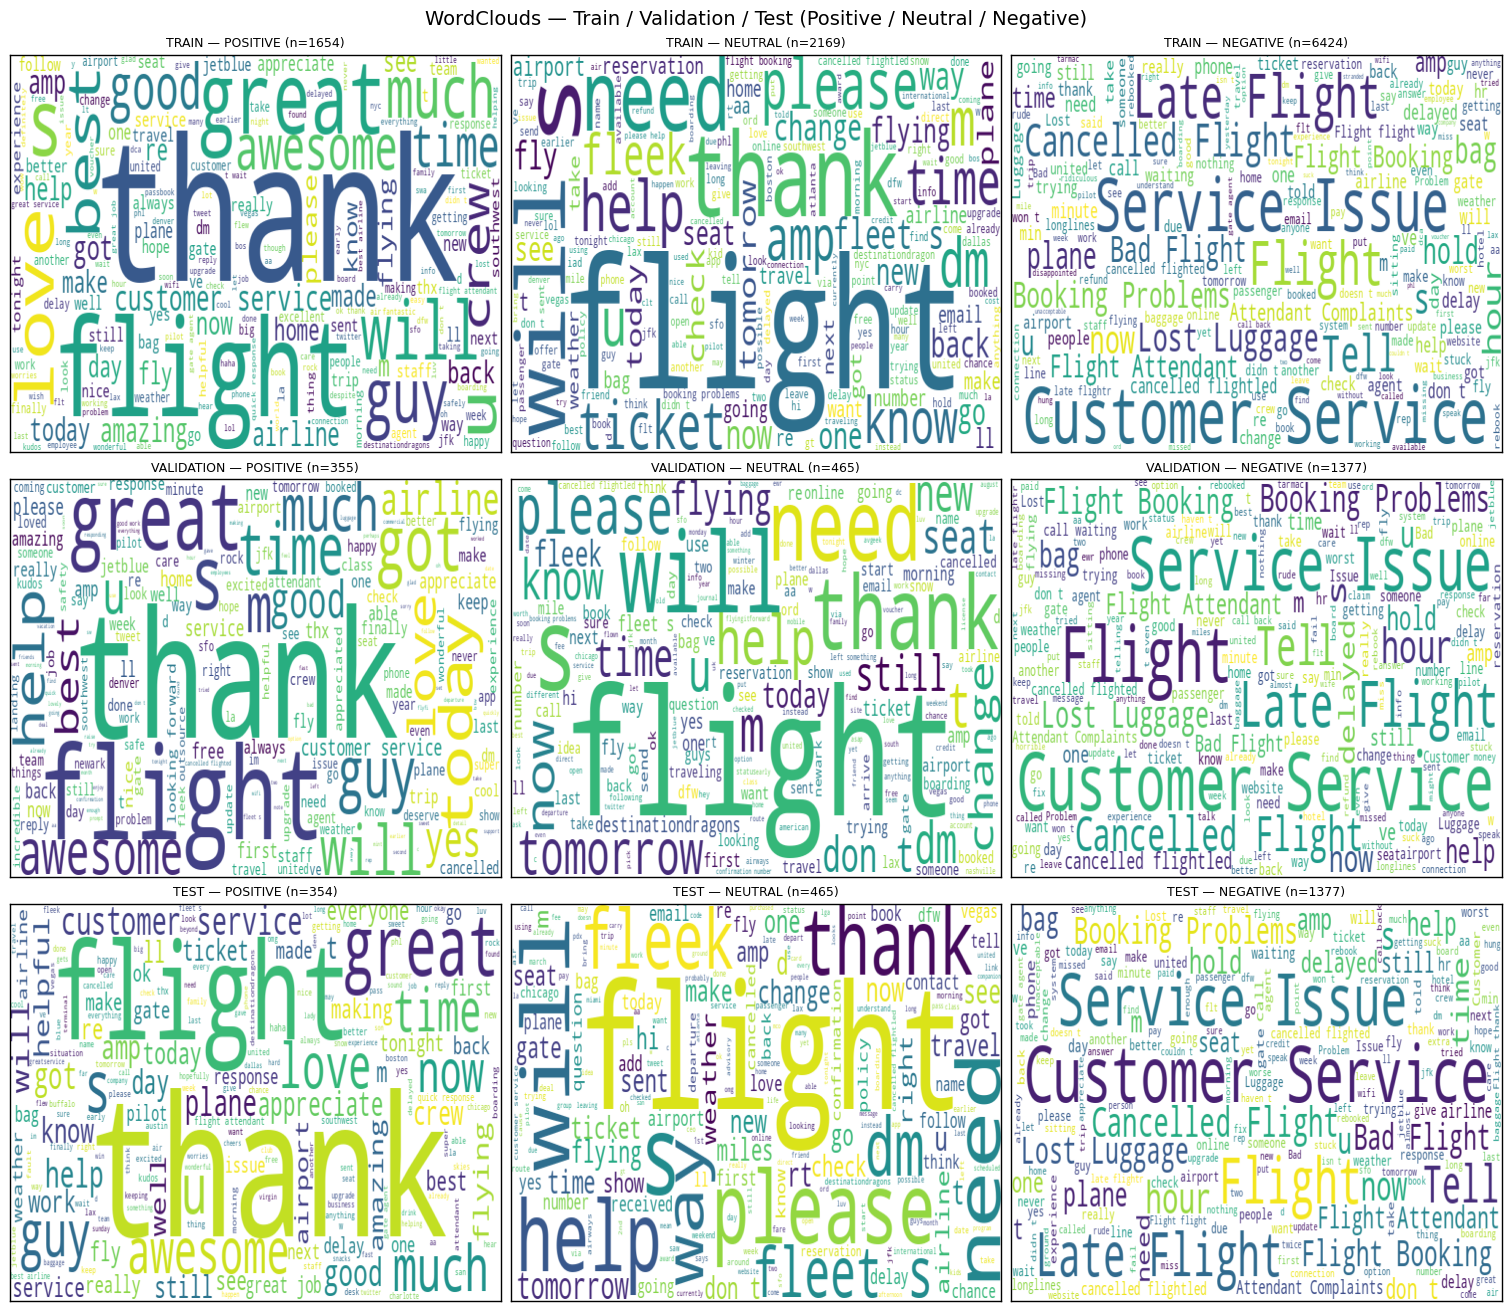


✅ Done. Boxed figures saved in: /content/ClassDis&WordClouds/wordclouds


In [11]:
OUT_DIR = "/content/ClassDis&WordClouds/wordclouds"
os.makedirs(OUT_DIR, exist_ok=True)

# Load datasets
train_df = pd.read_csv("/content/datasets/train.csv")
val_df   = pd.read_csv("/content/datasets/val.csv")
test_df  = pd.read_csv("/content/datasets/test.csv")

labels_map = {0: "negative", 1: "neutral", 2: "positive"}

def make_wordcloud(text):
    if not str(text).strip():
        return WordCloud(width=800, height=400, background_color='white', max_words=1).generate(" ")
    return WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

def style_box(ax, linewidth=1.0, color='black'):
    """Show a visible rectangular box around the subplot."""
    # show spines (frame) and hide ticks
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(linewidth)
        spine.set_edgecolor(color)

# -------------------------------
# Figure 1: Class Distributions
# -------------------------------
fig1, axs1 = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
for ax, (name, df) in zip(axs1, [("TRAIN", train_df), ("VALIDATION", val_df), ("TEST", test_df)]):
    counts = df['label'].value_counts().reindex([0, 1, 2], fill_value=0)
    names = [labels_map[i] for i in counts.index]
    ax.bar(names, counts.values)
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values) * 0.01, str(v), ha='center', fontsize=9)
    ax.set_title(f"{name}")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    style_box(ax, linewidth=1.2)

fig1.suptitle("Class Distributions — Train / Validation / Test", fontsize=14)
fig1.savefig(os.path.join(OUT_DIR, "class_distributions_boxed.png"), dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------
# Figure 2: WordClouds (3x3 grid)
# -------------------------------
col_order = [(2, "positive"), (1, "neutral"), (0, "negative")]
row_order = [("TRAIN", train_df), ("VALIDATION", val_df), ("TEST", test_df)]

fig2, axs2 = plt.subplots(3, 3, figsize=(15, 13), constrained_layout=True)
for r_idx, (split_name, df) in enumerate(row_order):
    for c_idx, (lbl, lbl_name) in enumerate(col_order):
        ax = axs2[r_idx, c_idx]
        texts = df.loc[df['label'] == lbl, 'text_clean'].astype(str).tolist()
        combined = " ".join(texts)
        wc = make_wordcloud(combined)
        # show image
        im = ax.imshow(wc, interpolation='bilinear', aspect='auto')
        # keep axes frame (spines) visible as box, but remove ticks
        style_box(ax, linewidth=1.0)
        # title on top of box
        ax.set_title(f"{split_name} — {lbl_name.upper()} (n={len(texts)})", fontsize=9, pad=6)

fig2.suptitle("WordClouds — Train / Validation / Test (Positive / Neutral / Negative)", fontsize=14)
fig2.savefig(os.path.join(OUT_DIR, "wordclouds_grid_boxed.png"), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Done. Boxed figures saved in:", OUT_DIR)


#Modelling

In [12]:
import os, gc, time, traceback
from collections import defaultdict
import numpy as np
import pandas as pd
import pickle, joblib

from sklearn.metrics import accuracy_score, f1_score, classification_report, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# safety / dirs
SEED = globals().get('SEED', 42)
np.random.seed(SEED); tf.random.set_seed(SEED)
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/models/results', exist_ok=True)

# basics
MAX_VOCAB = globals().get('MAX_VOCAB', 50000)
EPOCHS = 20

VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_VOCAB)
MAX_LEN = X_train_seq.shape[1]
NUM_CLASSES = int(len(np.unique(y_train)))
print(f"Vocab={VOCAB_SIZE}, MaxLen={MAX_LEN}, NumClasses={NUM_CLASSES}")

# class weights
classes = np.unique(y_train)
cw_arr = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c,w in zip(classes, cw_arr)}
print("class_weights:", class_weights)

# tf dataset helper
AUTOTUNE = tf.data.AUTOTUNE
def make_tf_dataset(X, y, batch_size=64, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y), seed=SEED)
    return ds.batch(batch_size).prefetch(AUTOTUNE)

#
# Model builders
#
def build_simple_rnn(vocab_size, max_len, embed_dim=128, rnn_units=64, dropout_rate=0.3, l2_reg=1e-4, dense_units=64, num_classes=3):
    inp = layers.Input((max_len,), dtype='int32')
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.SimpleRNN(rnn_units, activation='tanh', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inp, out)

def build_simple_lstm(vocab_size, max_len, embed_dim=128, lstm_units=64, dropout_rate=0.3, l2_reg=1e-4, dense_units=64, num_classes=3):
    inp = layers.Input((max_len,), dtype='int32')
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.LSTM(lstm_units, activation='tanh', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inp, out)

def build_simple_gru(vocab_size, max_len, embed_dim=128, gru_units=64, dropout_rate=0.3, l2_reg=1e-4, dense_units=64, num_classes=3):
    inp = layers.Input((max_len,), dtype='int32')
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.GRU(gru_units, activation='tanh', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inp, out)

def build_textcnn(vocab_size, max_len, embed_dim=128, filter_sizes=[3,4,5], num_filters=128, dense_units=64, dropout_rate=0.5, l2_reg=1e-4, num_classes=3):
    inp = layers.Input((max_len,), dtype='int32')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    conv_pools = []
    for k in filter_sizes:
        conv = layers.Conv1D(filters=num_filters, kernel_size=k, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        pooled = layers.GlobalMaxPooling1D()(conv)
        conv_pools.append(pooled)
    x = layers.Concatenate()(conv_pools) if len(conv_pools) > 1 else conv_pools[0]
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate/2)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inp, out)

def build_dnn(vocab_size, max_len, embed_dim=128, dense_units=128, dropout_rate=0.5, l2_reg=1e-4, num_classes=3):
    inp = layers.Input((max_len,), dtype='int32')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(max(64, dense_units//2), activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate/2)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inp, out)

#
# HPO grid
#
keras_configs = {
    "SimpleRNN": [
        {"name":"rnn_small",  "embed":64,  "rnn":32,  "dense":32,  "drop":0.30, "lr":2e-4, "batch":64},
        {"name":"rnn_med",    "embed":128, "rnn":64,  "dense":64,  "drop":0.35, "lr":1e-4, "batch":64},
        {"name":"rnn_large",  "embed":256, "rnn":128, "dense":128, "drop":0.4,  "lr":1e-4, "batch":32},
    ],
    "LSTM": [
        {"name":"lstm_small", "embed":64,  "lstm":32,  "dense":32,  "drop":0.30, "lr":2e-4, "batch":64},
        {"name":"lstm_med",   "embed":128, "lstm":64,  "dense":64,  "drop":0.35, "lr":1e-4, "batch":64},
        {"name":"lstm_large", "embed":256, "lstm":128, "dense":128, "drop":0.4,  "lr":1e-4, "batch":32},
    ],
    "GRU": [
        {"name":"gru_small",  "embed":64,  "gru":32,  "dense":32,  "drop":0.30, "lr":2e-4, "batch":64},
        {"name":"gru_med",    "embed":128, "gru":64,  "dense":64,  "drop":0.35, "lr":1e-4, "batch":64},
        {"name":"gru_large",  "embed":256, "gru":128, "dense":128, "drop":0.4,  "lr":1e-4, "batch":32},
    ],
    "TextCNN": [
        {"name":"cnn_small",  "embed":64,  "filters":64,  "dense":32,  "drop":0.5,  "lr":2e-4, "batch":64},
        {"name":"cnn_med",    "embed":128, "filters":128, "dense":64,  "drop":0.5,  "lr":1e-4, "batch":64},
        {"name":"cnn_large",  "embed":256, "filters":256, "dense":128, "drop":0.6,  "lr":1e-4, "batch":32},
    ],
    "DNN": [
        {"name":"dnn_small",  "embed":64,  "dense":64,  "drop":0.3, "lr":2e-4, "batch":64},
        {"name":"dnn_med",    "embed":128, "dense":128, "drop":0.4, "lr":1e-4, "batch":64},
        {"name":"dnn_large",  "embed":256, "dense":256, "drop":0.5, "lr":5e-5, "batch":32},
    ],
}

CALLBACKS_COMMON = lambda ckpt: [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=0),
    ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0)
]

# store results
keras_results = {}
failed = []

#
# Keras HPO loop (all families & presets)
#
for family, cfgs in keras_configs.items():
    print("\n" + "="*40)
    print("FAMILY:", family)
    for cfg in cfgs:
        cfg_name = cfg['name']
        print(f"\n-> Running {cfg_name} ({family})")
        try:
            # build model
            if family == "SimpleRNN":
                model = build_simple_rnn(VOCAB_SIZE, MAX_LEN, embed_dim=cfg["embed"], rnn_units=cfg["rnn"], dropout_rate=cfg["drop"], dense_units=cfg["dense"], num_classes=NUM_CLASSES)
            elif family == "LSTM":
                model = build_simple_lstm(VOCAB_SIZE, MAX_LEN, embed_dim=cfg["embed"], lstm_units=cfg["lstm"], dropout_rate=cfg["drop"], dense_units=cfg["dense"], num_classes=NUM_CLASSES)
            elif family == "GRU":
                model = build_simple_gru(VOCAB_SIZE, MAX_LEN, embed_dim=cfg["embed"], gru_units=cfg["gru"], dropout_rate=cfg["drop"], dense_units=cfg["dense"], num_classes=NUM_CLASSES)
            elif family == "TextCNN":
                model = build_textcnn(VOCAB_SIZE, MAX_LEN, embed_dim=cfg["embed"], num_filters=cfg["filters"], dense_units=cfg["dense"], dropout_rate=cfg["drop"], num_classes=NUM_CLASSES)
            elif family == "DNN":
                model = build_dnn(VOCAB_SIZE, MAX_LEN, embed_dim=cfg["embed"], dense_units=cfg["dense"], dropout_rate=cfg["drop"], num_classes=NUM_CLASSES)
            else:
                raise ValueError("Unknown family: " + str(family))

            opt = tf.keras.optimizers.Adam(learning_rate=cfg["lr"], clipnorm=1.0)
            model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # datasets
            train_ds = make_tf_dataset(X_train_seq, y_train, batch_size=cfg["batch"], shuffle=True)
            val_ds   = make_tf_dataset(X_val_seq, y_val, batch_size=cfg["batch"], shuffle=False)

            ckpt = f"/content/models/{cfg_name}_best.keras"
            os.makedirs(os.path.dirname(ckpt), exist_ok=True)
            callbacks = CALLBACKS_COMMON(ckpt)

            # train
            t0 = time.time()
            hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weights, verbose=1)
            t_elapsed = time.time() - t0
            print(f"Trained {cfg_name} in {t_elapsed:.1f}s")

            # eval
            train_eval = model.evaluate(train_ds, verbose=0)
            train_loss, train_acc = (train_eval[0], train_eval[1]) if len(train_eval)>=2 else (train_eval[0], None)

            val_preds = model.predict(val_ds, verbose=0)
            val_y_pred = np.argmax(val_preds, axis=1)
            val_acc = accuracy_score(y_val, val_y_pred)
            val_f1 = f1_score(y_val, val_y_pred, average='macro')

            # pick best epoch val_loss if present
            best_epoch = None
            val_loss_best = None
            if 'val_loss' in hist.history and len(hist.history['val_loss'])>0:
                best_epoch = int(np.argmin(hist.history['val_loss'])) + 1
                val_loss_best = float(hist.history['val_loss'][best_epoch-1])

            test_ds = make_tf_dataset(X_test_seq, y_test, batch_size=cfg['batch'], shuffle=False)
            test_preds = model.predict(test_ds, verbose=0)
            test_y_pred = np.argmax(test_preds, axis=1)
            test_acc = accuracy_score(y_test, test_y_pred)
            test_f1 = f1_score(y_test, test_y_pred, average='macro')

            test_eval = model.evaluate(test_ds, verbose=0)
            test_loss = float(test_eval[0]) if len(test_eval)>=1 else None

            # store results; keep model_object to allow immediate classification reports (will be deleted later)
            keras_results[cfg_name] = {
                "family": family,
                "cfg": cfg,
                "history": hist.history,
                "train_acc": float(train_acc) if train_acc is not None else None,
                "train_loss": float(train_loss) if train_loss is not None else None,
                "val_acc": float(val_acc),
                "val_loss": val_loss_best,
                "val_macro_f1": float(val_f1),
                "test_acc": float(test_acc),
                "test_macro_f1": float(test_f1),
                "test_loss": float(test_loss) if test_loss is not None else None,
                "best_epoch": best_epoch,
                "ckpt": ckpt,
                "model_object": model
            }

            print(f"-> done: {cfg_name}  val_acc={val_acc:.4f}  val_f1={val_f1:.4f}  test_acc={test_acc:.4f}  test_f1={test_f1:.4f}")

        except Exception as e:
            print(f"ERROR training {cfg_name} ({family}):", e)
            traceback.print_exc()
            failed.append((family, cfg_name, str(e)))
            # ensure we continue with next config
            try:
                tf.keras.backend.clear_session()
                del model
                gc.collect()
            except:
                pass
            continue

#
# Classical ML (TF-IDF): NB & RF (small grids)
#
# read cleaned CSVs
train_df = pd.read_csv("/content/datasets/train.csv")
val_df   = pd.read_csv("/content/datasets/val.csv")
test_df  = pd.read_csv("/content/datasets/test.csv")

train_texts = train_df['text_clean'].astype(str).tolist()
val_texts   = val_df['text_clean'].astype(str).tolist()
test_texts  = test_df['text_clean'].astype(str).tolist()
train_labels = train_df['label'].astype(int).values
val_labels   = val_df['label'].astype(int).values
test_labels  = test_df['label'].astype(int).values

# tfidf vectorizer
try:
    tfidf
except NameError:
    with open('/content/datasets/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf = pickle.load(f)

X_train_tfidf = tfidf.transform(train_texts)
X_val_tfidf   = tfidf.transform(val_texts)
X_test_tfidf  = tfidf.transform(test_texts)
print("TF-IDF shapes:", X_train_tfidf.shape)

# class weights local
classes_local = np.unique(train_labels)
cw_arr_local = compute_class_weight('balanced', classes=classes_local, y=train_labels)
class_weights_local = {int(c): float(w) for c,w in zip(classes_local, cw_arr_local)}
print("class_weights_local:", class_weights_local)

# Naive Bayes grid
nb_configs = [
    {"name":"nb_alpha_1.0", "alpha":1.0},
    {"name":"nb_alpha_0.5", "alpha":0.5},
    {"name":"nb_alpha_0.1", "alpha":0.1},
]
nb_results = {}
for cfg in nb_configs:
    try:
        print("Training NB:", cfg['name'])
        clf = MultinomialNB(alpha=cfg['alpha'])
        clf.fit(X_train_tfidf, train_labels)
        val_preds = clf.predict(X_val_tfidf)
        test_preds = clf.predict(X_test_tfidf)
        train_preds = clf.predict(X_train_tfidf)

        train_proba = clf.predict_proba(X_train_tfidf)
        val_proba = clf.predict_proba(X_val_tfidf)
        test_proba = clf.predict_proba(X_test_tfidf)

        nb_results[cfg['name']] = {
            "cfg": cfg,
            "val_acc": accuracy_score(val_labels, val_preds),
            "val_macro_f1": f1_score(val_labels, val_preds, average='macro'),
            "test_acc": accuracy_score(test_labels, test_preds),
            "test_macro_f1": f1_score(test_labels, test_preds, average='macro'),
            "train_acc": accuracy_score(train_labels, train_preds),
            "train_loss": float(log_loss(train_labels, train_proba)) if train_proba is not None else None,
            "val_loss": float(log_loss(val_labels, val_proba)) if val_proba is not None else None,
            "test_loss": float(log_loss(test_labels, test_proba)) if test_proba is not None else None,
            "model": clf
        }
        joblib.dump(clf, f"/content/models/{cfg['name']}_nb.joblib")
        print(" -> NB done:", cfg['name'], "val_acc:", nb_results[cfg['name']]['val_acc'])
    except Exception as e:
        print("NB failed:", cfg['name'], e)
        traceback.print_exc()

# Random Forest grid
rf_configs = [
    {"name":"rf_small", "n_estimators":200, "max_depth":20, "class_weight":"balanced"},
    {"name":"rf_med",   "n_estimators":300, "max_depth":40, "class_weight":"balanced_subsample"},
]
rf_results = {}
for cfg in rf_configs:
    try:
        print("Training RF:", cfg['name'])
        clf = RandomForestClassifier(n_estimators=cfg["n_estimators"], max_depth=cfg["max_depth"], class_weight=cfg["class_weight"], n_jobs=-1, random_state=SEED)
        clf.fit(X_train_tfidf, train_labels)
        val_preds = clf.predict(X_val_tfidf)
        test_preds = clf.predict(X_test_tfidf)
        train_preds = clf.predict(X_train_tfidf)

        train_proba = clf.predict_proba(X_train_tfidf)
        val_proba = clf.predict_proba(X_val_tfidf)
        test_proba = clf.predict_proba(X_test_tfidf)

        rf_results[cfg['name']] = {
            "cfg": cfg,
            "val_acc": accuracy_score(val_labels, val_preds),
            "val_macro_f1": f1_score(val_labels, val_preds, average='macro'),
            "test_acc": accuracy_score(test_labels, test_preds),
            "test_macro_f1": f1_score(test_labels, test_preds, average='macro'),
            "train_acc": accuracy_score(train_labels, train_preds),
            "train_loss": float(log_loss(train_labels, train_proba)) if train_proba is not None else None,
            "val_loss": float(log_loss(val_labels, val_proba)) if val_proba is not None else None,
            "test_loss": float(log_loss(test_labels, test_proba)) if test_proba is not None else None,
            "model": clf
        }
        joblib.dump(clf, f"/content/models/{cfg['name']}_rf.joblib")
        print(" -> RF done:", cfg['name'], "val_acc:", rf_results[cfg['name']]['val_acc'])
    except Exception as e:
        print("RF failed:", cfg['name'], e)
        traceback.print_exc()

#
# Summarize results across everything
#
all_results = {}
# keras_results (models)
for k,v in keras_results.items():
    all_results[k] = {
        "type": v.get("family","keras"),
        "train_acc": v.get('train_acc'),
        "val_acc": v.get('val_acc'),
        "test_acc": v.get('test_acc'),
        "val_macro_f1": v.get('val_macro_f1'),
        "test_macro_f1": v.get('test_macro_f1'),
        "train_loss": v.get('train_loss'),
        "val_loss": v.get('val_loss'),
        "test_loss": v.get('test_loss'),

    }
# classical
for k,v in nb_results.items():
    all_results[k] = {"type":"NaiveBayes", "train_acc":v.get('train_acc'), "val_acc":v.get('val_acc'), "test_acc":v.get('test_acc'), "val_macro_f1":v.get('val_macro_f1'), "test_macro_f1":v.get('test_macro_f1'), "train_loss":v.get('train_loss'), "val_loss":v.get('val_loss')}
for k,v in rf_results.items():
    all_results[k] = {"type":"RandomForest", "train_acc":v.get('train_acc'), "val_acc":v.get('val_acc'), "test_acc":v.get('test_acc'), "val_macro_f1":v.get('val_macro_f1'), "test_macro_f1":v.get('test_macro_f1'), "train_loss":v.get('train_loss'), "val_loss":v.get('val_loss')}

res_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index().rename(columns={'index':'model_name'})
cols = ['model_name','type','train_acc','val_acc','test_acc','train_loss','val_loss','test_loss','val_macro_f1','test_macro_f1']
res_df = res_df[[c for c in cols if c in res_df.columns]]
res_df = res_df.sort_values(by='val_acc', ascending=False).reset_index(drop=True)

print("\n=== SUMMARY ===")
display(res_df)
res_df.to_csv('/content/models/results/hpo_results_summary.csv', index=False)

# save full details
with open('/content/models/results/all_results.pkl', 'wb') as f:
    pickle.dump({
        'keras_results': keras_results,
        'nb_results': nb_results,
        'rf_results': rf_results,
        'summary': res_df,
        'failed': failed
    }, f)
print("Saved all results and failures list to /content/models/results/all_results.pkl")



Vocab=10829, MaxLen=128, NumClasses=3
class_weights: {0: 0.5317040265670403, 1: 1.574765637006301, 2: 2.06509471987102}

FAMILY: SimpleRNN

-> Running rnn_small (SimpleRNN)
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4838 - loss: 1.0605 - val_accuracy: 0.7970 - val_loss: 0.4511 - learning_rate: 2.0000e-04
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8118 - loss: 0.6159 - val_accuracy: 0.8503 - val_loss: 0.3099 - learning_rate: 2.0000e-04
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8295 - loss: 0.5235 - val_accuracy: 0.8534 - val_loss: 0.2850 - learning_rate: 2.0000e-04
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8392 - loss: 0.5125 - val_accuracy: 0.8594 - val_loss: 0.2774 - learning_rate: 2.0000e-04
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8547 - loss: 0.4868 - val_accuracy: 0.9067 - val_loss: 0.2379 - learning_rate: 2.0000e-04
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 2

,model_name,type,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss,val_macro_f1,test_macro_f1
0,gru_large,GRU,0.975505,0.935822,0.933971,0.098857,0.201802,0.203728,0.881991,0.878957
1,lstm_large,LSTM,0.969357,0.934456,0.930783,0.128726,0.200666,0.212144,0.879724,0.873056
2,lstm_med,LSTM,0.968967,0.934001,0.932605,0.126523,0.187966,0.198484,0.880303,0.878208
3,cnn_med,TextCNN,0.983117,0.933546,0.926230,0.110077,0.217361,0.231274,0.880732,0.867828
4,cnn_large,TextCNN,0.969747,0.933546,0.929417,0.190757,0.274773,0.282730,0.880670,0.873311
5,cnn_small,TextCNN,0.984874,0.932635,0.927596,0.096587,0.216437,0.216701,0.878936,0.869246
6,lstm_small,LSTM,0.968381,0.932635,0.929417,0.128772,0.184771,0.197329,0.878178,0.872105
7,gru_med,GRU,0.976676,0.931725,0.932149,0.097333,0.189579,0.191218,0.875994,0.877693
8,rnn_small,SimpleRNN,0.977945,0.931270,0.928962,0.090358,0.186090,0.195034,0.874772,0.873141
9,rnn_med,SimpleRNN,0.966429,0.925353,0.932149,0.138831,0.205901,0.199411,0.863915,0.876882


Saved all results and failures list to /content/models/results/all_results.pkl


# Classification-report diagrams for best model per family

Keras families to plot: ['SimpleRNN', 'LSTM', 'GRU', 'TextCNN', 'DNN']
Classical models to plot: ['NaiveBayes', 'RandomForest']


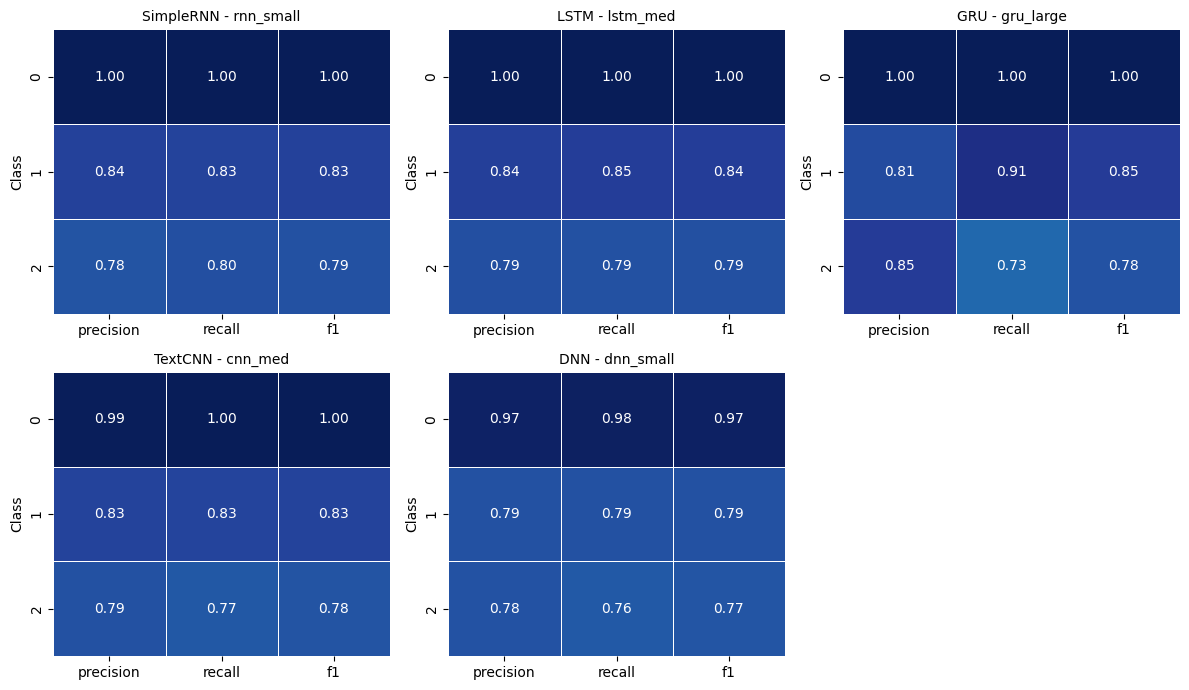

Saved: /content/models/results/cls_reports/keras_bests.png


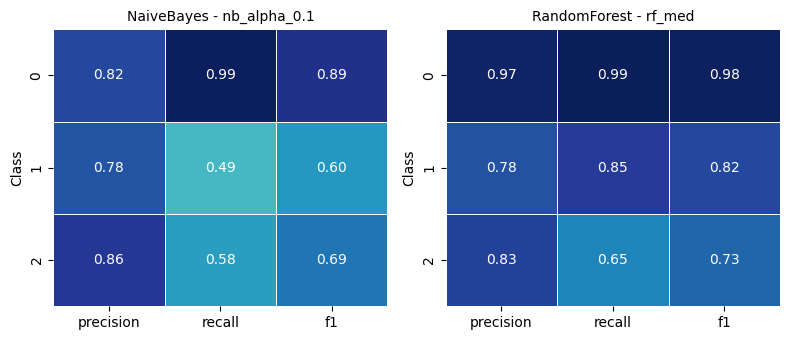

Saved: /content/models/results/cls_reports/sklearn_bests.png


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
import pickle

os.makedirs("/content/models/results/cls_reports", exist_ok=True)

# Helper: pick best by val_macro_f1
def pick_best_by_val_macro(results_dict):
    best_key, best_score = None, -999
    for k, v in results_dict.items():
        s = v.get("val_macro_f1")
        if s is None: continue
        if s > best_score:
            best_score, best_key = s, k
    return best_key

# --- Build best-per-family maps ---
keras_by_family = defaultdict(dict)
best_keras_entries = {}
best_classical_entries = {}

if "keras_results" in globals():
    for k, v in keras_results.items():
        fam = v.get("family", "keras")
        keras_by_family[fam][k] = v
    for fam, members in keras_by_family.items():
        best_key = pick_best_by_val_macro(members)
        if best_key:
            best_keras_entries[fam] = members[best_key]

if "nb_results" in globals() and isinstance(nb_results, dict) and nb_results:
    best_nb = pick_best_by_val_macro(nb_results)
    if best_nb:
        best_classical_entries["NaiveBayes"] = nb_results[best_nb]

if "rf_results" in globals() and isinstance(rf_results, dict) and rf_results:
    best_rf = pick_best_by_val_macro(rf_results)
    if best_rf:
        best_classical_entries["RandomForest"] = rf_results[best_rf]

print("Keras families to plot:", list(best_keras_entries.keys()))
print("Classical models to plot:", list(best_classical_entries.keys()))

# Utility: unified prediction extraction
def get_preds_for_entry(family, entry):
    model_obj = entry.get("model_object") if entry.get("family") else entry.get("model")
    cfg = entry.get("cfg", {})
    if family in keras_by_family:
        if model_obj is None:
            raise RuntimeError(f"No model_object for {family}")
        batch = cfg.get("batch", 64)
        test_ds = make_tf_dataset(X_test_seq, y_test, batch_size=batch, shuffle=False)
        preds = model_obj.predict(test_ds, verbose=0)
        return y_test, np.argmax(preds, axis=1)
    elif family in ("NaiveBayes", "RandomForest"):
        clf = entry.get("model")
        if clf is None:
            raise RuntimeError(f"No classical model for {family}")
        if "X_test_tfidf" in globals():
            X_test_local = X_test_tfidf
        else:
            with open("/content/datasets/tfidf_vectorizer.pkl", "rb") as f:
                _tfidf = pickle.load(f)
            X_test_local = _tfidf.transform(test_texts if "test_texts" in globals() else test_df["text_clean"].tolist())
        y_true = test_labels if "test_labels" in globals() else test_df["label"].astype(int).values
        return y_true, clf.predict(X_test_local)
    else:
        raise RuntimeError(f"Unknown family: {family}")

# ===============================
# Figure 1: Keras models (3x2 grid)
# ===============================
if best_keras_entries:
    keras_items = list(best_keras_entries.items())
    n = len(keras_items)
    rows, cols = (2, 3) if n > 3 else (1, n)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
    axes = np.array(axes).reshape(-1)
    for ax in axes[len(keras_items):]:
        ax.axis("off")

    for ax, (fam, entry) in zip(axes, keras_items):
        display_name = f"{fam} - {entry.get('cfg', {}).get('name', '')}"
        try:
            y_true, y_pred = get_preds_for_entry(fam, entry)
            crep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
            class_keys = [k for k in crep.keys() if k not in ("accuracy", "macro avg", "weighted avg")]
            df_cr = pd.DataFrame({k: crep[k] for k in class_keys}).T[["precision", "recall", "f1-score"]].rename(columns={"f1-score": "f1"})
            sns.heatmap(df_cr.astype(float), annot=True, fmt=".2f", cmap="YlGnBu",
                        linewidths=0.4, linecolor="white", vmin=0.0, vmax=1.0, ax=ax, cbar=False)
            ax.set_title(display_name, fontsize=10)
            ax.set_xlabel("")
            ax.set_ylabel("Class")
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{display_name}\n{e}", ha="center", va="center", fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    outpath = "/content/models/results/cls_reports/keras_bests.png"
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", outpath)

# ===============================
# Figure 2: Classical (2 in one row)
# ===============================
if best_classical_entries:
    classical_items = list(best_classical_entries.items())
    cols = len(classical_items)
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 3.5))
    if cols == 1:
        axes = [axes]
    for ax, (fam, entry) in zip(axes, classical_items):
        display_name = f"{fam} - {entry.get('cfg', {}).get('name', '')}"
        try:
            y_true, y_pred = get_preds_for_entry(fam, entry)
            crep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
            class_keys = [k for k in crep.keys() if k not in ("accuracy", "macro avg", "weighted avg")]
            df_cr = pd.DataFrame({k: crep[k] for k in class_keys}).T[["precision", "recall", "f1-score"]].rename(columns={"f1-score": "f1"})
            sns.heatmap(df_cr.astype(float), annot=True, fmt=".2f", cmap="YlGnBu",
                        linewidths=0.4, linecolor="white", vmin=0.0, vmax=1.0, ax=ax, cbar=False)
            ax.set_title(display_name, fontsize=10)
            ax.set_xlabel("")
            ax.set_ylabel("Class")
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{display_name}\n{e}", ha="center", va="center", fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    outpath2 = "/content/models/results/cls_reports/sklearn_bests.png"
    plt.savefig(outpath2, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", outpath2)

# Clear session
try:
    K.clear_session()
except:
    pass


#Summary table comparing best model per family

,family,model_name,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss,val_macro_f1,test_macro_f1,best_epoch
0,GRU,gru_large,0.975505,0.935822,0.933971,0.098857,0.201802,0.203728,0.881991,0.878957,5.0
1,LSTM,lstm_med,0.968967,0.934001,0.932605,0.126523,0.187966,0.198484,0.880303,0.878208,9.0
2,TextCNN,cnn_med,0.983117,0.933546,0.926230,0.110077,0.217361,0.231274,0.880732,0.867828,15.0
3,SimpleRNN,rnn_small,0.977945,0.931270,0.928962,0.090358,0.186090,0.195034,0.874772,0.873141,9.0
4,RandomForest,rf_med,0.980775,0.919436,0.908015,0.377362,0.473209,0.477675,0.861392,0.842584,NaN
5,DNN,dnn_small,0.970528,0.904870,0.902550,0.131026,0.269645,0.282449,0.849766,0.845061,8.0
6,NaiveBayes,nb_alpha_0.1,0.952571,0.824306,0.815574,0.157512,0.433281,0.444318,0.744509,0.729121,NaN


Wrote summary CSV to: /content/models/results/best_models_summary.csv


<Figure size 1000x820 with 0 Axes>

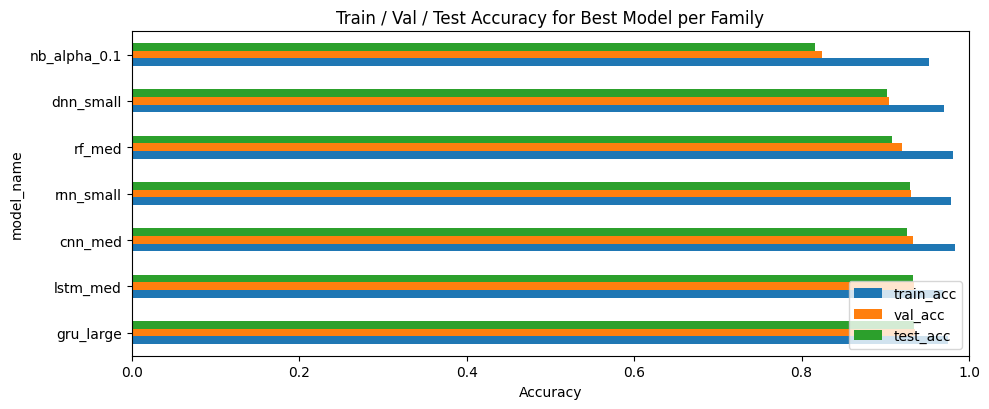

Wrote acc comparison plot to: /content/models/results/best_models_acc_comparison.png


,model_name,train_acc,val_acc,test_acc,val_minus_train,test_minus_val
0,gru_large,0.975505,0.935822,0.933971,-0.039683,-0.001851
1,lstm_med,0.968967,0.934001,0.932605,-0.034966,-0.001396
2,cnn_med,0.983117,0.933546,0.926230,-0.049571,-0.007316
3,rnn_small,0.977945,0.931270,0.928962,-0.046675,-0.002308
4,rf_med,0.980775,0.919436,0.908015,-0.061339,-0.011421
5,dnn_small,0.970528,0.904870,0.902550,-0.065658,-0.002320
6,nb_alpha_0.1,0.952571,0.824306,0.815574,-0.128266,-0.008732


In [14]:
import os
import pandas as pd
from collections import defaultdict

def pick_best_key(results_dict):
    best_key = None
    best_score = -999
    for k,v in results_dict.items():
        s = v.get('val_macro_f1')
        if s is None: continue
        if s > best_score:
            best_score = s
            best_key = k
    return best_key

rows = []

# Keras families
keras_by_family = defaultdict(dict)
if 'keras_results' in globals():
    for k,v in keras_results.items():
        fam = v.get('family','keras')
        keras_by_family[fam][k] = v
    for fam, members in keras_by_family.items():
        best_key = pick_best_key(members)
        if not best_key: continue
        best = members[best_key]
        row = {
            'family': fam,
            'model_name': best_key,
            'train_acc': best.get('train_acc'),
            'val_acc': best.get('val_acc'),
            'test_acc': best.get('test_acc'),
            'train_loss': best.get('train_loss'),
            'val_loss': best.get('val_loss'),
            'test_loss': best.get('test_loss'),
            'val_macro_f1': best.get('val_macro_f1'),
            'test_macro_f1': best.get('test_macro_f1'),
            'best_epoch': best.get('best_epoch'),
            # removed time columns as requested
        }
        rows.append(row)

# NaiveBayes best
if 'nb_results' in globals() and isinstance(nb_results, dict) and nb_results:
    best_nb_key = pick_best_key(nb_results)
    if best_nb_key:
        b = nb_results[best_nb_key]
        rows.append({
            'family': 'NaiveBayes',
            'model_name': best_nb_key,
            'train_acc': b.get('train_acc'),
            'val_acc': b.get('val_acc'),
            'test_acc': b.get('test_acc'),
            'train_loss': b.get('train_loss'),
            'val_loss': b.get('val_loss'),
            'test_loss': b.get('test_loss'),
            'val_macro_f1': b.get('val_macro_f1'),
            'test_macro_f1': b.get('test_macro_f1'),
            'best_epoch': None
        })

# RandomForest best
if 'rf_results' in globals() and isinstance(rf_results, dict) and rf_results:
    best_rf_key = pick_best_key(rf_results)
    if best_rf_key:
        b = rf_results[best_rf_key]
        rows.append({
            'family': 'RandomForest',
            'model_name': best_rf_key,
            'train_acc': b.get('train_acc'),
            'val_acc': b.get('val_acc'),
            'test_acc': b.get('test_acc'),
            'train_loss': b.get('train_loss'),
            'val_loss': b.get('val_loss'),
            'test_loss': b.get('test_loss'),
            'val_macro_f1': b.get('val_macro_f1'),
            'test_macro_f1': b.get('test_macro_f1'),
            'best_epoch': None
        })

# Create DataFrame
summary_df = pd.DataFrame(rows)
# sort by val_acc (desc) if available else val_macro_f1
if 'val_acc' in summary_df.columns and summary_df['val_acc'].notna().any():
    summary_df = summary_df.sort_values(by=['val_acc'], ascending=False).reset_index(drop=True)
elif 'val_macro_f1' in summary_df.columns:
    summary_df = summary_df.sort_values(by=['val_macro_f1'], ascending=False).reset_index(drop=True)

# Display & save
display(summary_df)
summary_csv = "/content/models/results/best_models_summary.csv"
os.makedirs(os.path.dirname(summary_csv), exist_ok=True)
summary_df.to_csv(summary_csv, index=False)
print("Wrote summary CSV to:", summary_csv)

# Also create a quick bar-plot comparing train/val/test acc for each best model
import matplotlib.pyplot as plt
import numpy as np

# ensure numeric and fill NaNs with 0 for plotting
plot_df = summary_df.copy().set_index('model_name')[['train_acc','val_acc','test_acc']].astype(float)
plot_df = plot_df.fillna(0.0)

plt.figure(figsize=(10, 4 + 0.6*len(plot_df)))
plot_df.plot(kind='barh', stacked=False, figsize=(10, max(4,0.6*len(plot_df))))
plt.xlabel("Accuracy")
plt.xlim(0,1.0)
plt.title("Train / Val / Test Accuracy for Best Model per Family")
plt.legend(loc='lower right')
plt.tight_layout()
outplot = "/content/models/results/best_models_acc_comparison.png"
plt.savefig(outplot, dpi=200, bbox_inches='tight')
plt.show()
print("Wrote acc comparison plot to:", outplot)

# If you want, also compute simple deltas (overfitting indicator)
if not summary_df.empty:
    summary_df['val_minus_train'] = summary_df['val_acc'] - summary_df['train_acc']
    summary_df['test_minus_val'] = summary_df['test_acc'] - summary_df['val_acc']
    display(summary_df[['model_name','train_acc','val_acc','test_acc','val_minus_train','test_minus_val']])


#Accuracy Plots vs Epochs — Train vs Validation Accuracy for All Keras Families and Sklearn Models


Plotting Keras best-model accuracy subplots...


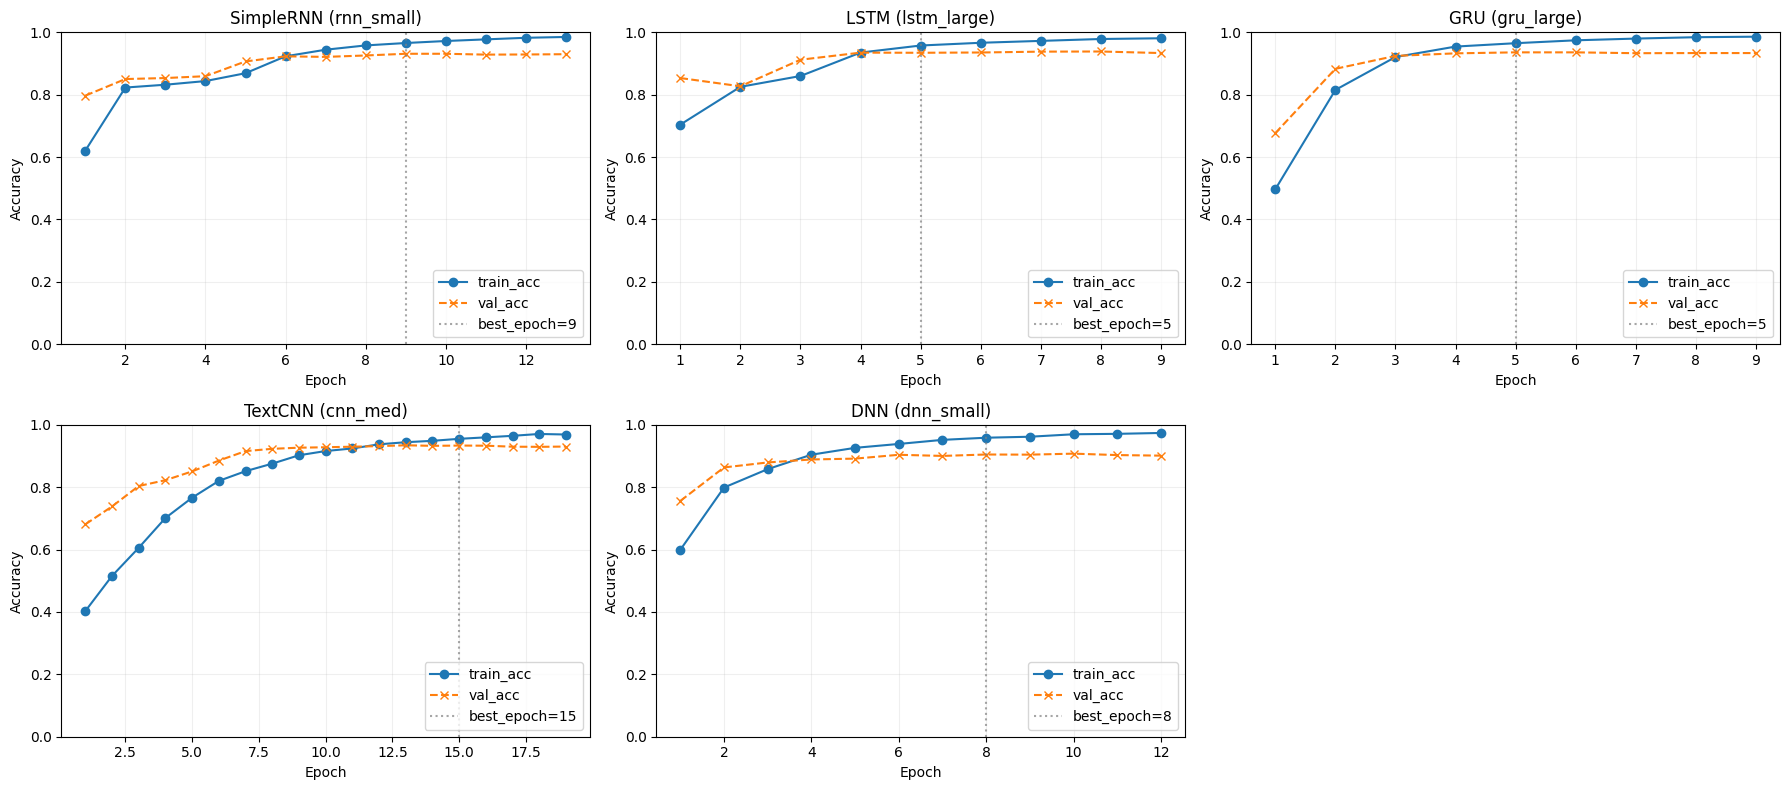

Saved: /content/models/results/plots/keras_all_families_accuracy_subplots.png

Plotting combined sklearn subplots (NaiveBayes & RandomForest)...


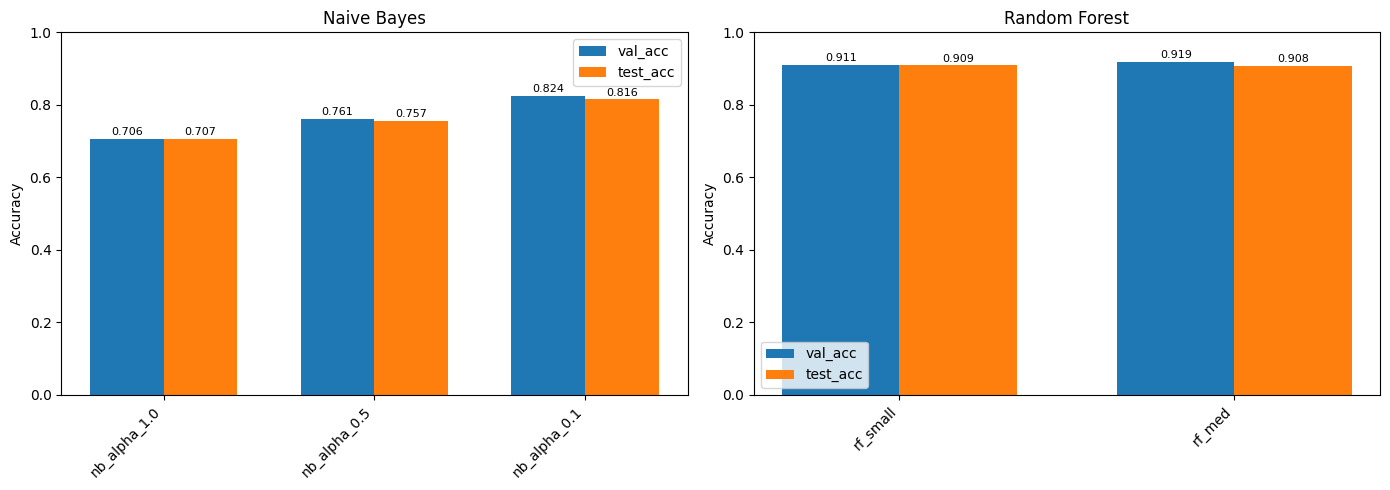

Saved: /content/models/results/plots/sklearn_nb_rf_subplots.png

✅ All plots saved to: /content/models/results/plots


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

OUT_DIR = "/content/models/results/plots"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------- Helper functions -----------------------
def get_series_safe(hist, keys):
    for k in keys:
        if k in hist:
            try:
                return np.array(hist[k], dtype=float)
            except Exception:
                return np.array([float(x) for x in hist[k]])
    return np.array([])

def pad_to(n, arr):
    out = np.full(n, np.nan)
    out[:min(n, arr.size)] = arr[:min(n, arr.size)]
    return out

def pick_best_by_valacc(results_dict):
    best_key, best_score = None, -1e9
    for k,v in results_dict.items():
        va = v.get('val_acc', v.get('val_macro_f1'))
        score = float(va) if va is not None else -1e9
        if score > best_score:
            best_score = score; best_key = k
    return best_key

# -------------------- Keras Histories ------------------------
keras_by_family = defaultdict(dict)

if 'keras_results' in globals() and isinstance(keras_results, dict):
    for name, info in keras_results.items():
        fam = info.get('family') or info.get('type') or 'Keras'
        hist = info.get('history', {}) or {}
        keras_by_family[fam][name] = hist

if 'dnn_results' in globals() and isinstance(dnn_results, dict):
    for name, info in dnn_results.items():
        hist = info.get('history', {}) or {}
        keras_by_family['DNN'][name] = hist

# -------------------- Keras Subplots -------------------------
print("Plotting Keras best-model accuracy subplots...")
families = list(keras_by_family.keys())
if families:
    n_cols = min(3, len(families))
    n_rows = int(np.ceil(len(families) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(-1)

    for idx, fam in enumerate(families):
        ax = axes[idx]
        members = keras_by_family[fam]
        if not members:
            continue
        best_name = pick_best_by_valacc({
            k: {'val_acc': keras_results.get(k, {}).get('val_acc'),
                'val_macro_f1': keras_results.get(k, {}).get('val_macro_f1')}
            for k in members.keys()
        }) or next(iter(members.keys()))
        history = members[best_name] or {}

        train_acc = get_series_safe(history, ['accuracy', 'acc', 'train_acc'])
        val_acc = get_series_safe(history, ['val_accuracy', 'val_acc'])
        n_epochs = max(train_acc.size, val_acc.size)
        if n_epochs == 0:
            ax.set_title(f"{fam}: No data"); ax.axis("off"); continue
        train_acc, val_acc = pad_to(n_epochs, train_acc), pad_to(n_epochs, val_acc)
        epochs = np.arange(1, n_epochs+1)

        ax.plot(epochs, train_acc, marker='o', label='train_acc')
        ax.plot(epochs, val_acc, marker='x', linestyle='--', label='val_acc')

        meta = keras_results.get(best_name, {})
        be = meta.get('best_epoch')
        if be:
            ax.axvline(be, color='gray', linestyle=':', alpha=0.7, label=f'best_epoch={be}')

        ax.set_title(f"{fam} ({best_name})")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 1); ax.grid(alpha=0.2); ax.legend(loc='lower right')

    # Hide empty axes
    for j in range(len(families), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    keras_outfile = os.path.join(OUT_DIR, "keras_all_families_accuracy_subplots.png")
    plt.savefig(keras_outfile, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {keras_outfile}")
else:
    print("No keras_results found, skipping Keras subplot section.")

# -------------------- Sklearn Combined Subplots ----------------------------
def get_sklearn_acc_arrays(results_dict):
    names, val_accs, test_accs = [], [], []
    for name, info in results_dict.items():
        names.append(name)
        val_accs.append(float(info.get('val_acc', np.nan)))
        test_accs.append(float(info.get('test_acc', np.nan)))
    return names, np.array(val_accs), np.array(test_accs)

print("\nPlotting combined sklearn subplots (NaiveBayes & RandomForest)...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plots_done = False

if 'nb_results' in globals() and nb_results:
    names, val_accs, test_accs = get_sklearn_acc_arrays(nb_results)
    x = np.arange(len(names)); w = 0.35
    axes[0].bar(x - w/2, val_accs, w, label='val_acc')
    axes[0].bar(x + w/2, test_accs, w, label='test_acc')
    axes[0].set_xticks(x); axes[0].set_xticklabels(names, rotation=45, ha='right')
    axes[0].set_ylim(0, 1); axes[0].set_title("Naive Bayes")
    for i,(va,ta) in enumerate(zip(val_accs,test_accs)):
        axes[0].text(i - w/2, va + 0.01, f"{va:.3f}", ha='center', fontsize=8)
        axes[0].text(i + w/2, ta + 0.01, f"{ta:.3f}", ha='center', fontsize=8)
    plots_done = True
else:
    axes[0].axis("off")

if 'rf_results' in globals() and rf_results:
    names, val_accs, test_accs = get_sklearn_acc_arrays(rf_results)
    x = np.arange(len(names)); w = 0.35
    axes[1].bar(x - w/2, val_accs, w, label='val_acc')
    axes[1].bar(x + w/2, test_accs, w, label='test_acc')
    axes[1].set_xticks(x); axes[1].set_xticklabels(names, rotation=45, ha='right')
    axes[1].set_ylim(0, 1); axes[1].set_title("Random Forest")
    for i,(va,ta) in enumerate(zip(val_accs,test_accs)):
        axes[1].text(i - w/2, va + 0.01, f"{va:.3f}", ha='center', fontsize=8)
        axes[1].text(i + w/2, ta + 0.01, f"{ta:.3f}", ha='center', fontsize=8)
    plots_done = True
else:
    axes[1].axis("off")

if plots_done:
    for ax in axes: ax.legend(); ax.set_ylabel("Accuracy")
    plt.tight_layout()
    skl_outfile = os.path.join(OUT_DIR, "sklearn_nb_rf_subplots.png")
    plt.savefig(skl_outfile, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {skl_outfile}")
else:
    print("No sklearn results found, skipping sklearn subplots.")

print("\n✅ All plots saved to:", OUT_DIR)


#Loss Plots vs Epochs — Train vs Validation Loss for All Keras Families and Sklearn Models


Plotting Keras family loss subplots...


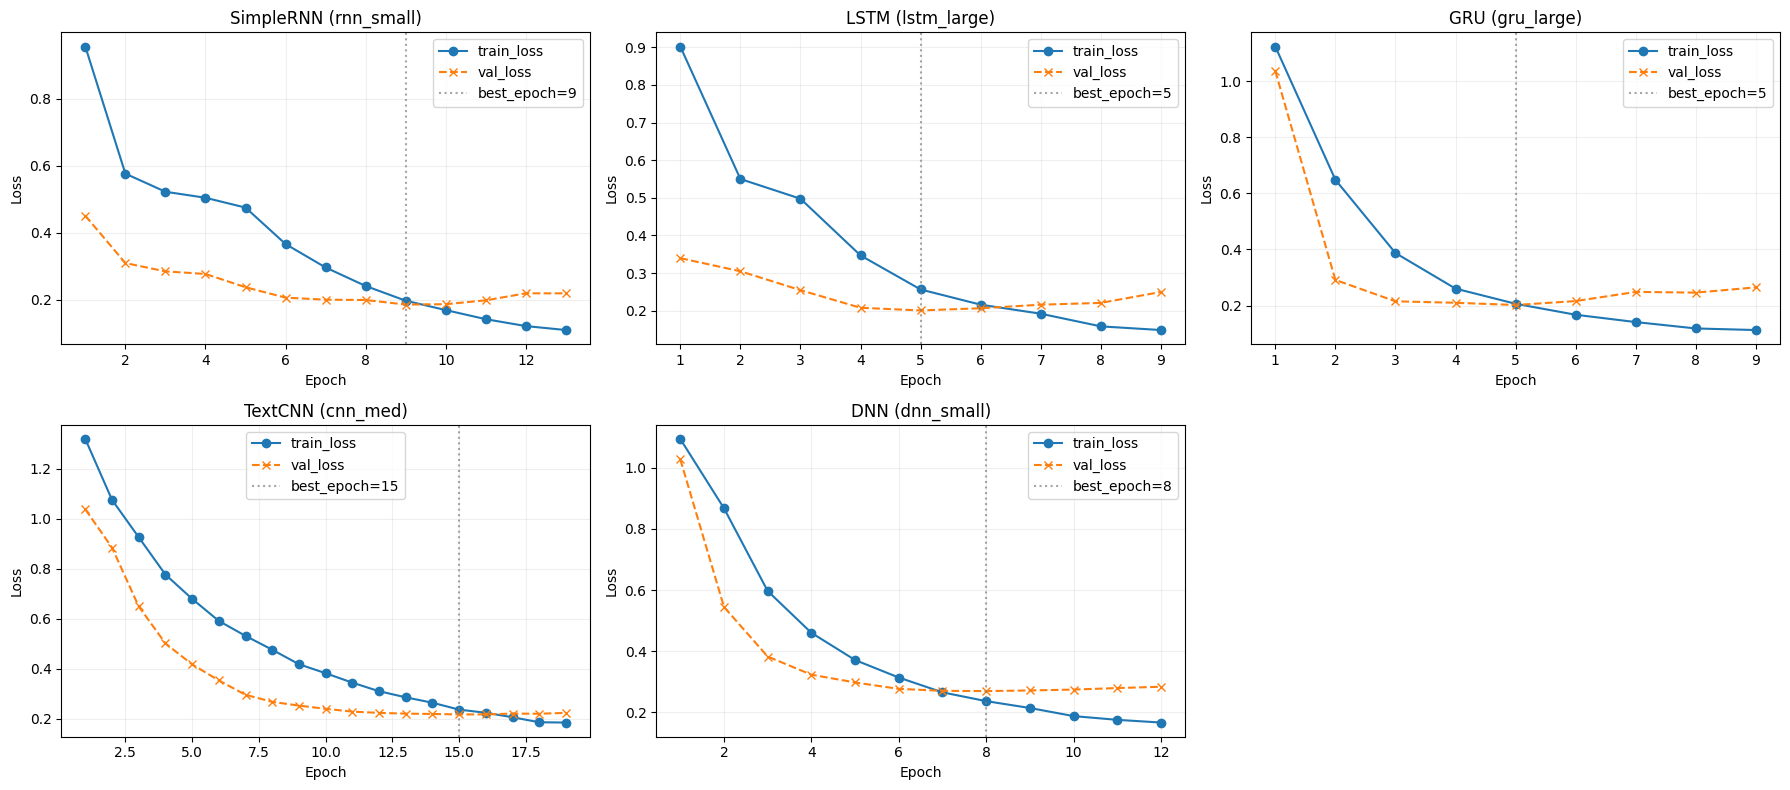

Saved: /content/models/results/plots/keras_all_families_loss_subplots.png

Plotting sklearn loss subplots (NB & RF)...


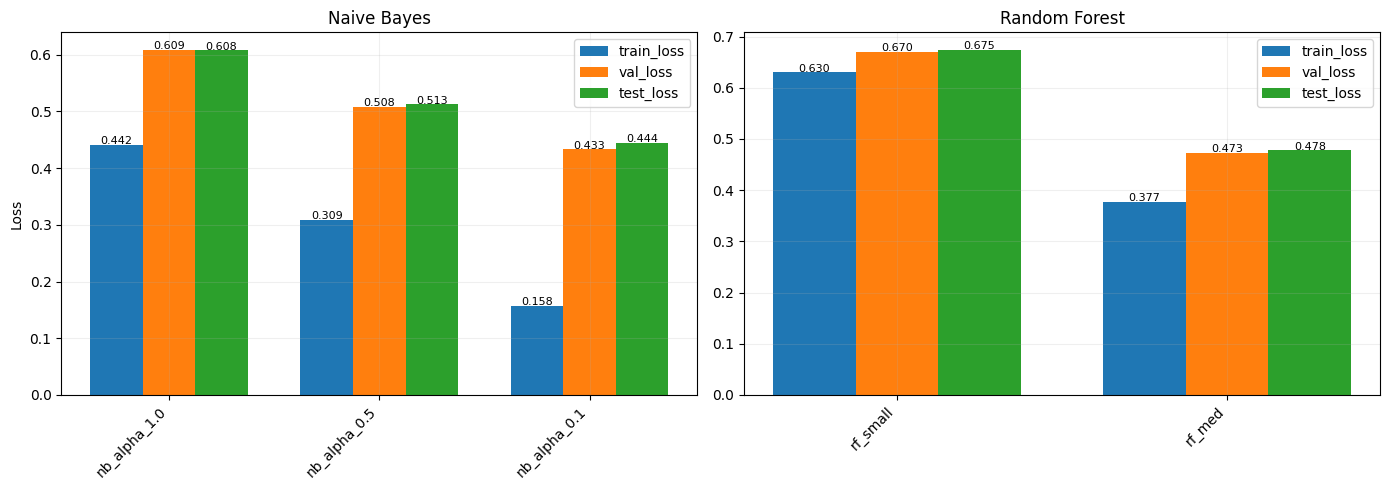

Saved: /content/models/results/plots/sklearn_nb_rf_loss_subplots.png

✅ All loss subplot figures saved to: /content/models/results/plots


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

OUT_DIR = "/content/models/results/plots"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helper functions ----------------
def to_array_safe(x):
    try:
        return np.array(x, dtype=float)
    except Exception:
        try:
            return np.array([float(i) for i in x])
        except Exception:
            return np.array([])

def pad_to(n, arr):
    out = np.full(n, np.nan)
    out[:min(n, arr.size)] = arr[:min(n, arr.size)]
    return out

def pick_best_key_by_summary_or_history(name_list, family, keras_results_map, summary_df):
    """Pick best model name for a family using summary_df val_acc, fallback to lowest val_loss in history."""
    if summary_df is not None:
        sub = summary_df[summary_df['type'] == family]
        if not sub.empty:
            try:
                row = sub.loc[sub['val_acc'].idxmax()]
                best_name = row['model_name']
                if best_name in name_list:
                    return best_name
            except Exception:
                pass
    best_name, best_val = None, np.inf
    for name in name_list:
        hist = (keras_results_map.get(name, {}) or {}).get('history', {}) if keras_results_map else {}
        if isinstance(hist, dict):
            val_loss_series = to_array_safe(hist.get('val_loss', []))
            if val_loss_series.size > 0:
                val_loss_min = float(np.nanmin(val_loss_series))
                if val_loss_min < best_val:
                    best_val = val_loss_min
                    best_name = name
    return best_name or (name_list[0] if name_list else None)

# ---------------- Load summary ----------------
summary_df = None
summary_path = "/content/models/results/hpo_results_summary.csv"
if os.path.exists(summary_path):
    try:
        summary_df = pd.read_csv(summary_path)
    except Exception:
        summary_df = None

# ---------------- Collect Keras families ----------------
keras_by_family = defaultdict(dict)
if 'keras_results' in globals() and isinstance(keras_results, dict):
    for name, info in keras_results.items():
        fam = info.get('family') or info.get('type') or 'Keras'
        keras_by_family[fam][name] = info.get('history', {}) or {}

if 'dnn_results' in globals() and isinstance(dnn_results, dict):
    for name, info in dnn_results.items():
        keras_by_family['DNN'][name] = info.get('history', {}) or {}

# ---------------- Keras subplot: loss curves ----------------
print("Plotting Keras family loss subplots...")
families = list(keras_by_family.keys())
if families:
    n_cols = min(3, len(families))
    n_rows = int(np.ceil(len(families) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(-1)

    for idx, fam in enumerate(families):
        ax = axes[idx]
        members = keras_by_family[fam]
        if not members:
            ax.axis("off")
            continue

        names = list(members.keys())
        best_name = pick_best_key_by_summary_or_history(names, fam, keras_results if 'keras_results' in globals() else {}, summary_df)
        hist = members.get(best_name, {}) or {}
        train_loss = to_array_safe(hist.get('loss', []))
        val_loss = to_array_safe(hist.get('val_loss', []))
        n_epochs = max(train_loss.size, val_loss.size)
        if n_epochs == 0:
            ax.set_title(f"{fam}: No loss data"); ax.axis("off"); continue

        train_loss, val_loss = pad_to(n_epochs, train_loss), pad_to(n_epochs, val_loss)
        epochs = np.arange(1, n_epochs+1)
        ax.plot(epochs, train_loss, marker='o', label='train_loss')
        ax.plot(epochs, val_loss, marker='x', linestyle='--', label='val_loss')

        meta = keras_results.get(best_name, {}) if 'keras_results' in globals() else {}
        be = meta.get('best_epoch')
        if be:
            ax.axvline(int(be), color='gray', linestyle=':', alpha=0.7, label=f'best_epoch={be}')

        ax.set_title(f"{fam} ({best_name})")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
        ax.grid(alpha=0.2); ax.legend()

    for j in range(len(families), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    keras_loss_file = os.path.join(OUT_DIR, "keras_all_families_loss_subplots.png")
    plt.savefig(keras_loss_file, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {keras_loss_file}")
else:
    print("No keras_results found — skipping Keras loss subplot section.")

# ---------------- Sklearn subplot: loss bars ----------------
def get_loss_arrays(results_dict):
    names, train_ls, val_ls, test_ls = [], [], [], []
    for k,v in results_dict.items():
        names.append(k)
        train_ls.append(float(v.get('train_loss', np.nan)) if v.get('train_loss') is not None else np.nan)
        val_ls.append(float(v.get('val_loss', np.nan)) if v.get('val_loss') is not None else np.nan)
        test_ls.append(float(v.get('test_loss', np.nan)) if v.get('test_loss') is not None else np.nan)
    return names, np.array(train_ls), np.array(val_ls), np.array(test_ls)

print("\nPlotting sklearn loss subplots (NB & RF)...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plots_done = False

if 'nb_results' in globals() and nb_results:
    names, train_ls, val_ls, test_ls = get_loss_arrays(nb_results)
    x = np.arange(len(names)); w = 0.25
    axes[0].bar(x - w, train_ls, w, label='train_loss')
    axes[0].bar(x, val_ls, w, label='val_loss')
    axes[0].bar(x + w, test_ls, w, label='test_loss')
    axes[0].set_xticks(x); axes[0].set_xticklabels(names, rotation=45, ha='right')
    axes[0].set_title("Naive Bayes"); axes[0].set_ylabel("Loss")
    for i,(a,b,c) in enumerate(zip(train_ls,val_ls,test_ls)):
        if not np.isnan(a): axes[0].text(i - w, a + 1e-3, f"{a:.3f}", ha='center', fontsize=8)
        if not np.isnan(b): axes[0].text(i, b + 1e-3, f"{b:.3f}", ha='center', fontsize=8)
        if not np.isnan(c): axes[0].text(i + w, c + 1e-3, f"{c:.3f}", ha='center', fontsize=8)
    plots_done = True
else:
    axes[0].axis("off")

if 'rf_results' in globals() and rf_results:
    names, train_ls, val_ls, test_ls = get_loss_arrays(rf_results)
    x = np.arange(len(names)); w = 0.25
    axes[1].bar(x - w, train_ls, w, label='train_loss')
    axes[1].bar(x, val_ls, w, label='val_loss')
    axes[1].bar(x + w, test_ls, w, label='test_loss')
    axes[1].set_xticks(x); axes[1].set_xticklabels(names, rotation=45, ha='right')
    axes[1].set_title("Random Forest")
    for i,(a,b,c) in enumerate(zip(train_ls,val_ls,test_ls)):
        if not np.isnan(a): axes[1].text(i - w, a + 1e-3, f"{a:.3f}", ha='center', fontsize=8)
        if not np.isnan(b): axes[1].text(i, b + 1e-3, f"{b:.3f}", ha='center', fontsize=8)
        if not np.isnan(c): axes[1].text(i + w, c + 1e-3, f"{c:.3f}", ha='center', fontsize=8)
    plots_done = True
else:
    axes[1].axis("off")

if plots_done:
    for ax in axes: ax.legend(); ax.grid(alpha=0.2)
    plt.tight_layout()
    skl_loss_file = os.path.join(OUT_DIR, "sklearn_nb_rf_loss_subplots.png")
    plt.savefig(skl_loss_file, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {skl_loss_file}")
else:
    print("No sklearn results found — skipping sklearn subplot section.")

print("\n✅ All loss subplot figures saved to:", OUT_DIR)


#Predict

In [21]:
# Predict using BEST model per family (one prediction per family)
import os, re, pickle, joblib, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import normalize
from glob import glob
import pandas as pd

# Paths (adjust if needed)
MODELS_DIR = "/content/models"
TOKENIZER_PATH = "/content/datasets/keras_tokenizer.pkl"
TFIDF_PATH = "/content/datasets/tfidf_vectorizer.pkl"
SUMMARY_PATH = "/content/models/results/hpo_results_summary.csv"

LABEL_MAP = {0: "Negative", 1: "Neutral", 2: "Positive"}
MAX_LEN = globals().get('MAX_LEN', 128)

# load tokenizer + tfidf
with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)
with open(TFIDF_PATH, "rb") as f:
    tfidf = pickle.load(f)

def clean_text(s: str):
    s = s.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def make_seq(text, max_len=MAX_LEN):
    seq = tokenizer.texts_to_sequences([text])
    return pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")

def predict_with_keras_path(model_path, text):
    model = tf.keras.models.load_model(model_path)
    probs = model.predict(make_seq(text), verbose=0)[0]
    tf.keras.backend.clear_session()
    del model
    probs = np.array(probs, dtype=float)
    probs = probs / probs.sum()
    idx = int(np.argmax(probs))
    return idx, probs

def predict_with_sklearn_path(model_path, text):
    clf = joblib.load(model_path)
    X = tfidf.transform([text])
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X)[0]
    else:
        pred = clf.predict(X)
        probs = np.zeros(3)
        probs[int(pred[0])] = 1.0
    try:
        probs = np.array(probs, dtype=float)
        probs = probs / probs.sum()
    except Exception:
        pass
    del clf
    idx = int(np.argmax(probs))
    return idx, probs

# Helper: find best per family from summary CSV (preferred)
def best_per_family_from_summary(summary_path):
    if not os.path.exists(summary_path):
        return None
    df = pd.read_csv(summary_path)
    # ensure columns present
    if 'type' not in df.columns or 'model_name' not in df.columns:
        return None
    out = {}
    for fam, sub in df.groupby('type'):
        # pick by val_acc then val_macro_f1
        if 'val_acc' in sub.columns and not sub['val_acc'].isna().all():
            row = sub.loc[sub['val_acc'].idxmax()]
        elif 'val_macro_f1' in sub.columns and not sub['val_macro_f1'].isna().all():
            row = sub.loc[sub['val_macro_f1'].idxmax()]
        else:
            row = sub.iloc[0]
        out[fam] = row['model_name']
    return out

# Helper: fallback to globals (keras_results, dnn_results, nb_results, rf_results)
def best_per_family_from_globals():
    out = {}
    # keras_results / dnn_results
    for dict_name in ('keras_results','dnn_results','nb_results','rf_results'):
        if dict_name in globals() and isinstance(globals()[dict_name], dict):
            d = globals()[dict_name]
            for k,v in d.items():
                fam = v.get('family') or v.get('type') or ( 'DNN' if dict_name=='dnn_results' else dict_name.replace('_results','').title())
                # store candidate list
                out.setdefault('__candidates__', {}).setdefault(fam, []).append((k, float(v.get('val_acc') or -1e9), float(v.get('val_macro_f1') or -1e9)))
    res = {}
    for fam, cand in (out.get('__candidates__') or {}).items():
        # sort by val_acc, fallback val_macro_f1
        cand_sorted = sorted(cand, key=lambda x: (x[1], x[2]), reverse=True)
        res[fam] = cand_sorted[0][0]
    return res

# Pick best-per-family
best_map = best_per_family_from_summary(SUMMARY_PATH)
if best_map is None or not best_map:
    best_map = best_per_family_from_globals()

if not best_map:
    raise RuntimeError("Could not find best-per-family metadata (no summary and no *_results dicts). Run HPO first.")

print("Best model per family (selected names):")
for fam, name in best_map.items():
    print(f" - {fam}: {name}")
print("="*60)

# locate model files for each selected model name and predict
def find_model_file_for_name(model_name):
    # first try keras .keras files
    for p in glob(os.path.join(MODELS_DIR, f"{model_name}*.keras")) + glob(os.path.join(MODELS_DIR, f"*{model_name}*.keras")):
        return p, 'keras'
    # then joblib / pkl
    for p in glob(os.path.join(MODELS_DIR, f"{model_name}*.joblib")) + glob(os.path.join(MODELS_DIR, f"{model_name}*.pkl")) + glob(os.path.join(MODELS_DIR, f"*{model_name}*.joblib")) + glob(os.path.join(MODELS_DIR, f"*{model_name}*.pkl")):
        return p, 'sklearn'
    # also try any file that contains the model_name
    for p in glob(os.path.join(MODELS_DIR, "*")):
        bn = os.path.basename(p)
        if model_name in bn:
            if bn.endswith('.keras'):
                return p, 'keras'
            if bn.endswith('.joblib') or bn.endswith('.pkl'):
                return p, 'sklearn'
    return None, None

# prompt user
text = input("Enter a sentence to analyze sentiment: ").strip()
text_clean = clean_text(text)
print("\nCleaned text:", text_clean)
print("="*60)

# iterate families and predict using that family's best model only
for fam, model_name in best_map.items():
    model_file, kind = find_model_file_for_name(str(model_name))
    if not model_file:
        print(f"[{fam}] Could not find saved file for '{model_name}' in {MODELS_DIR} — skipping.")
        continue
    try:
        if kind == 'keras':
            idx, probs = predict_with_keras_path(model_file, text_clean)
            print(f"🧠 {fam} (Keras) [{os.path.basename(model_file)}] -> {LABEL_MAP[idx]} ({probs[idx]:.4f})")
        else:
            idx, probs = predict_with_sklearn_path(model_file, text_clean)
            print(f"🤖 {fam} (Sklearn) [{os.path.basename(model_file)}] -> {LABEL_MAP[idx]} ({probs[idx]:.4f})")
        for i,p in enumerate(probs):
            print(f"   {LABEL_MAP[i]}: {p:.4f}")
    except Exception as e:
        print(f"[{fam}] Error during prediction with {model_file}: {e}")
    print("-"*60)

print("Done — predictions shown for each family's BEST model.")


Best model per family (selected names):
 - DNN: dnn_small
 - GRU: gru_large
 - LSTM: lstm_large
 - NaiveBayes: nb_alpha_0.1
 - RandomForest: rf_med
 - SimpleRNN: rnn_small
 - TextCNN: cnn_med
Enter a sentence to analyze sentiment: i love u

Cleaned text: i love u
🧠 DNN (Keras) [dnn_small_best.keras] -> Positive (0.9814)
   Negative: 0.0000
   Neutral: 0.0186
   Positive: 0.9814
------------------------------------------------------------
🧠 GRU (Keras) [gru_large_best.keras] -> Positive (0.7583)
   Negative: 0.0249
   Neutral: 0.2168
   Positive: 0.7583
------------------------------------------------------------
🧠 LSTM (Keras) [lstm_large_best.keras] -> Positive (0.6688)
   Negative: 0.0304
   Neutral: 0.3008
   Positive: 0.6688
------------------------------------------------------------
🤖 NaiveBayes (Sklearn) [nb_alpha_0.1_nb.joblib] -> Positive (0.9239)
   Negative: 0.0374
   Neutral: 0.0387
   Positive: 0.9239
------------------------------------------------------------
🤖 RandomFor